In [1]:
import os

import numpy as np
import scipy

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import lightning as L

from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger

# Load Dataset

In [2]:
data = scipy.io.loadmat('../data/barmovie0113extended.data', squeeze_me=True)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'rep_begin_time', 'rep_end_time', 'PickedCells', 'SpikeTimes', 'peak_times', 'stim'])

In [3]:
len(data['SpikeTimes']), len(data['PickedCells'])

(230, 123)

One time unit is equivalent to 0.1 milliseconds = `1e-4` seconds

In [4]:
SECONDS_PER_UNIT = 1e-4

In [5]:
DATASET_LENGTH = (np.max(data['peak_times']) - np.min(data['peak_times'])) * SECONDS_PER_UNIT

In [6]:
def spikes_in_interval(data, t1, t2, neuron_indices=data['PickedCells']):
    for i in neuron_indices:
        all_spikes = data['SpikeTimes'][i] * SECONDS_PER_UNIT
        i1, i2 = np.searchsorted(all_spikes, [t1, t2])
        yield all_spikes[i1:i2]

Let's plot a portion of the dataset

Text(0.5, 0, 'time (s)')

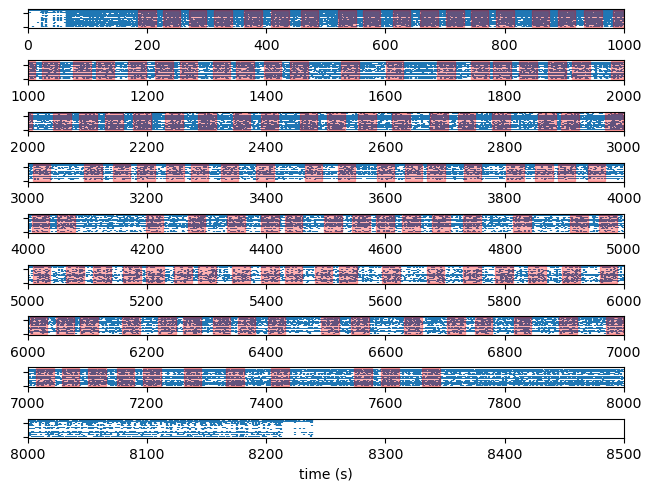

In [7]:
interval_length = 1000.0
MAX_LEN = 8500.0

intervals = np.arange(0, MAX_LEN, interval_length)
fig, axs = plt.subplots(len(intervals), 1, constrained_layout=True)

for ax, interval_start in zip(axs, intervals):

    interval = (interval_start, min(MAX_LEN, interval_start + interval_length))

    ax.set_xlim(*interval)

    spikes = spikes_in_interval(data, *interval)
    ax.eventplot(spikes, linestyles="dotted")

    times = np.arange(interval[0], interval[1], 0.5)

    ax.fill_between(
        times,
        0.0,
        123,
        where=(
            np.digitize(times, data["rep_begin_time"] * SECONDS_PER_UNIT)
            > np.digitize(times, data["rep_end_time"] * SECONDS_PER_UNIT)
        ),
        color='red',
        alpha=0.3,
        zorder=2
    )
    ax.set(yticklabels=[])

axs[-1].set_xlabel("time (s)")

In [8]:
STIMULUS_START = data['peak_times'][0] * SECONDS_PER_UNIT
REPITITIONS_START = data['rep_begin_time'][0] * SECONDS_PER_UNIT
REPITITIONS_END = data['rep_end_time'][-1] * SECONDS_PER_UNIT
STIMULUS_END = data['peak_times'][-1] * SECONDS_PER_UNIT

STIMULUS_START, REPITITIONS_START, REPITITIONS_END, STIMULUS_END

(np.float64(66.0316),
 np.float64(184.80120000000002),
 np.float64(7691.4654),
 np.float64(8213.754200000001))

## Utility Class
Write a utility class to load the dataset, so we can use the data for ML tasks.

First, we time-discretize the data

In [9]:
BIN_WIDTH = 100
f"Bin width is set to {BIN_WIDTH * SECONDS_PER_UNIT * 1000} milliseconds."

'Bin width is set to 10.0 milliseconds.'

In [ ]:
from torch.utils.data import Dataset


class NeuronDataSet(Dataset):
    def __init__(self, filename, neurons=[0], intervals=None, delta_t=BIN_WIDTH, cnn=False):
        super().__init__()
        self.data = scipy.io.loadmat(filename, squeeze_me=True)
        self.cnn = cnn
        self.neurons = neurons
        if intervals is None:
            self.intervals = np.stack(
                (self.data["rep_begin_time"], self.data["rep_end_time"]), axis=-1
            )
        else:
            self.intervals = np.array(intervals).reshape((-1, 2))
        self.delta_t = delta_t
        self.stimulus_std = float(np.std(self.data["stim"]))

    def __len__(self):
        return self.intervals.shape[0]

    def __getitem__(self, index):
        t1, t2 = self.intervals[index]
        return self.time_discretized_spikes(t1, t2)

    def time_discretized_spikes(self, t_start, t_end):
        grid = np.arange(t_start, t_end, self.delta_t)

        peak_times = self.data["peak_times"][:-2]
        idx = np.searchsorted(peak_times, grid)
        stimulus = (
            torch.tensor(
                self.data["stim"][idx],
                dtype=torch.float32,
            )
            / self.stimulus_std
        )

        spikes_binned = []
        for k, n in enumerate(self.neurons):
            spike_times = self.data["SpikeTimes"][n]
            hist, _ = np.histogram(spike_times, bins=np.concat([grid, [t_end]]))
            spikes_binned.append(torch.tensor(hist, dtype=torch.uint8))

        t_seconds = torch.tensor(
            (grid - t_start) * SECONDS_PER_UNIT, dtype=torch.float32
        )
        dim = -1 if not self.cnn else 0
        return (
            t_seconds,
            stimulus,
            torch.stack(spikes_binned, dim=dim),
        )


def collate_time_series(batch):
    # first unzip the batch
    t_batch, s_batch, x_batch = zip(*batch)

    # Find the minimum sequence length
    min_len = min(s.shape[0] for s in s_batch)

    t_truncated = torch.stack([t[:min_len] for t in t_batch], dim=1)
    s_truncated = torch.stack(
        [s[:min_len] for s in s_batch], dim=1
    )  # (min_len, batch_size, ...)
    x_truncated = torch.stack(
        [x[:min_len] for x in x_batch], dim=1
    )  # (min_len, batch_size, ...)

    return t_truncated, s_truncated, x_truncated  # , list(x_embedded)

In [14]:
full_dataset = NeuronDataSet(
    "../data/barmovie0113extended.data",
    [0, 1, 2, 3],
    [data["peak_times"][0], data["rep_begin_time"][0]],
    cnn=False
)
t, s, x = collate_time_series([b for b in full_dataset])
t.shape, s.shape, x.shape

(torch.Size([11877, 1]), torch.Size([11877, 1]), torch.Size([11877, 1, 4]))

Plot one repition of the stimulus. In the lower part we see the spike counts per time bin.

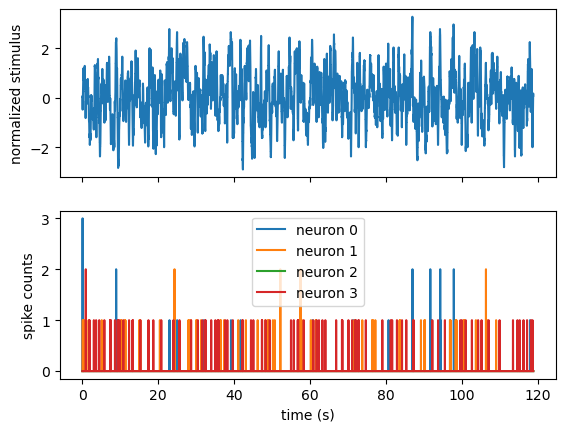

In [15]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(t[:, 0], s[:, 0])
ax1.set_ylabel('normalized stimulus')
for i in range(x.size(2)):
    ax2.plot(t[:, 0].numpy(), x[:, 0, i].numpy(), label=f'neuron {i}')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('spike counts')
ax2.legend()

# ML Models

In [ ]:
class ConditionalSpikeRNN(nn.Module):
    def __init__(self, n_neurons: int, hidden_size: int, num_layers: int = 1, kernel_size=10):
        super().__init__()
        self.hidden_dim = hidden_size
        self.num_layers = num_layers
        self.n_neurons = n_neurons

        # initial convolution layer over input
        self.conv = nn.Conv1d(1, hidden_size, kernel_size, padding=kernel_size-1)
        
        # RNN layer (stimulus dimension is 1)
        self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=False)
        self.h_0 = nn.Parameter(torch.randn(num_layers, 1, hidden_size))

        # Linear layer to output spike prob for each neuron
        self.output_layer = nn.Linear(hidden_size, n_neurons)

    def forward(self, s: torch.Tensor, x: torch.Tensor):
        seq_len, batch_size, n_neurons = x.size()

        if seq_len != s.size(0):
            raise ValueError(f"Sequence lengths do not match.")

        if n_neurons != self.n_neurons:
            raise ValueError(f"Wrong shape of x: {x.size()}. Expected last dimension {self.n_neurons}.")

        if s.ndim == 2:
            s = s.unsqueeze(-1) # (seq_len, batch_size, 1)

        # first convolution layer
        x = self.conv(s.permute((1, 2, 0)))[:, :, :seq_len] # (batch_size, hidden_size, seq_len)

        # Expand h_0 to match batch size
        h_0 = self.h_0.expand(-1, batch_size, -1).contiguous()

        # Forward through RNN
        x, _ = self.rnn(x.permute((2, 0, 1)), h_0)

        output = self.output_layer(x)  # (seq_len, batch_size, n_neurons)

        # returns the intensities
        return output

In [123]:
class ConditionalSpikeCNN(nn.Module):
    def __init__(self, n_neurons: int, hidden_size: int, num_layers: int = 1, kernel_size=10):
        super().__init__()
        self.hidden_dim = hidden_size
        self.num_layers = num_layers
        self.n_neurons = n_neurons
        self.kernel_size = kernel_size
        self.pad_size = (kernel_size - 1) * num_layers

        layers = []
        for i in range(num_layers):
            in_size = (1 + n_neurons) if i == 0 else hidden_size
            layers.append(nn.Conv1d(in_size, hidden_size, kernel_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())

        self.conv_net = nn.Sequential(
            *layers,
            # 1x1 convolution layer to output spike intensity for each neuron
            nn.Conv1d(hidden_size, n_neurons, 1)
        )

    def forward(self, s: torch.Tensor, x: torch.Tensor, cache: torch.Tensor | None = None):
        """
        Forward pass of the CNN. S is the stimulus, x the neuronal outputs.
        When using this function, x needs be shifted-right wrt so s. I.e.
        s = [s_0, s_1, s_2, ...]
        x = [0.0, x_0, x_1, ...]
        """
        seq_len, _batch_size, n_neurons = x.size()

        if seq_len != s.size(0):
            raise ValueError(f"Sequence lengths do not match. s: {s.size(0)} x: {seq_len}")

        if n_neurons != self.n_neurons:
            raise ValueError(f"Wrong shape of x: {x.size()}. Expected last dimension {self.n_neurons}.")

        if s.ndim == 2:
            s = s.transpose(0, 1).unsqueeze(1) # (batch_size, 1, seq_len)
        else:
            raise ValueError(f"Wrong shape of s: {s.shape}, expected (seq_len, batch_size)")

        conv_input = torch.cat([s, x.permute((1, 2, 0))], dim=1) # (batch_size, n_neurons + 1, seq_len)

        if cache is None:
            conv_input = F.pad(conv_input, (self.pad_size, 0), mode='constant', value=0)  # (batch_size, n_neurons + 1, seq_len + self.pad_size)
        else:
            assert cache.size(-1) == self.pad_size, f"Cache has wrong size {cache.size(-1)}, expected {self.pad_size}"
            conv_input = torch.cat([cache, conv_input], dim=-1)
        cache = conv_input[..., -self.pad_size:]
        
        output = self.conv_net(conv_input) # (batch_size, n_neurons, seq_len)
        
        # returns the log-intensities (seq_len, batch_size, n_neurons)
        return output.permute((2, 0, 1)), cache
    
    @torch.no_grad()
    def sample(self, s: torch.Tensor):
        seq_len, batch_size = s.size()
        device = s.device

        # output tensor
        x = torch.zeros((seq_len, batch_size, self.n_neurons), device=device)

        cache = None

        for t in range(seq_len):
            if t == 0:
                out, cache = self(s[[t]], x[[0]], cache)
            else:
                out, cache = self(s[[t]], x[[t-1]], cache)
            log_intensity = out.squeeze(0).clamp(-10, 10)
            x[t] = torch.poisson(log_intensity.exp())
            
        return x

In [120]:
def shift_right(x):
    x = torch.roll(x, 1, dims=0)
    x[0].zero_()
    return x

We train using the poisson negative log likelihood loss function. The Poisson likelihood of a process with intensity $\lambda$ is given by
$$
\mathrm{P}(N(t) = n) = \frac{(\lambda t)^n}{n!} e^{-\lambda t} \,.
$$
If we time-discretize our spikes with time-interval $\Delta t$ and the poisson intensity at time $t_i = i \Delta t$ is given by $\lambda_i$, then the probability of observing $n_i$ spikes in the time-interval $[t_i, t_{i+1})$ is given by
$$
\mathrm{P}(N_i = n_i) = \frac{(\lambda_i \Delta t)^{n_i}}{n_i !} e^{-\lambda_i \Delta t} \,.
$$
Therefore, the negative log likelihood is given by
$$
\mathcal{L} = - \sum_i \ln\mathrm{P}(N_i = n_i) = \sum_i - n_i \ln \lambda_i \Delta t + \lambda_i \Delta t + \ln(n_i !)
$$

In [121]:
from scipy.stats import pearsonr

class SpikeModel(L.LightningModule):
    def __init__(self, n_neurons: int, hidden_size: int, num_layers: int = 1, kernel_size=None, model_type='RNN'):
        super().__init__()
        self.save_hyperparameters()
        if model_type == 'RNN':
            if kernel_size is not None:
                raise ValueError('cannot set kernel size for RNN.')
            self.net = ConditionalSpikeRNN(n_neurons, hidden_size, num_layers)
        elif model_type == 'CNN':
            if kernel_size is None:
                kernel_size = 10
            self.net = ConditionalSpikeCNN(n_neurons, hidden_size, num_layers, kernel_size=kernel_size)
        else:
            raise ValueError(f"unsupported model type {model_type}")
        self.loss_fn = nn.PoissonNLLLoss(log_input=True)

    def training_step(self, batch, batch_idx):
        _, s, x = batch
        log_intensity, _ = self.net(s, shift_right(x))
        train_loss = self.loss_fn(log_intensity, x)
        self.log("train_loss", train_loss, prog_bar=True, batch_size=x.size(1))
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        _, s, x = batch
        log_intensity, _ = self.net(s, shift_right(x))
        val_loss = self.loss_fn(log_intensity, x)

        # compute correlation
        actual_rate = x.mean(1, dtype=torch.float32)
        assert isinstance(self.net, ConditionalSpikeCNN)
        self.net.eval()
        with torch.no_grad():
            predicted_rate = self.net.sample(s).mean(1)
        self.net.train()
        corr = pearsonr(predicted_rate, actual_rate, axis=0).statistic # pyright: ignore[reportAttributeAccessIssue]

        values = {"val_loss": val_loss, "corr": np.nanmean(corr)}
        # Log validations
        self.log_dict(values, prog_bar=True, batch_size=x.size(1))
        return val_loss

    def configure_optimizers(self): # type: ignore
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-4)
        total_steps = self.trainer.estimated_stepping_batches
        assert isinstance(total_steps, int)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-1, total_steps=total_steps)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            }
        }

# Input SDE

## Stochastic Harmonic Oscillator

In [24]:
TAU = 50e-3 # seconds
OMEGA_0 = 9.42 # per second

Because the damping coefficient
$$
\gamma = \frac{1}{2 \omega_0 \tau}
$$
is larger than 1, the system is overdamped. However, the system is close to critical damping (i.e. $\gamma \approx 1$).

In [25]:
DAMPING_COEFFICIENT = 1.0 / (2 * OMEGA_0 * TAU)
DAMPING_COEFFICIENT

1.0615711252653928

In [26]:
STATIONARY_SIGMA = torch.tensor([1.0, 1/(4*DAMPING_COEFFICIENT**2)])

This defines a stochastically driven harmonic oscillator with variance $\langle x^2 \rangle = 1$.

In [27]:
import torchsde

class StochasticHarmonicOscillator(nn.Module):
    noise_type = 'scalar'
    sde_type = 'ito'

    def __init__(self, damping_coefficient = DAMPING_COEFFICIENT, tau = TAU):
        super().__init__()

        self.A = torch.tensor([[0.0, 1.0],
                               [-1 / (4 * damping_coefficient**2), - 1.0]], dtype=torch.float32) / tau
        
        self.B = torch.tensor([[0.0, 1.0 / (np.sqrt(2.0) * damping_coefficient)]], dtype=torch.float32) / np.sqrt(tau)

    # Drift
    def f(self, t, y):
        return y @ self.A.T

    # Diffusion
    def g(self, t, y):
        return self.B.expand(y.size(0), 2).unsqueeze(-1)

In [28]:
y0 = torch.randn(1000, 2) * STATIONARY_SIGMA
model = StochasticHarmonicOscillator()
model.A, model.B

(tensor([[  0.0000,  20.0000],
         [ -4.4368, -20.0000]]),
 tensor([[0.0000, 2.9789]]))

Generate for one second

In [29]:
time = t[:101, 0]
time

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900, 1.0000])

In [59]:
y = torchsde.sdeint(model, y0, time, method='euler', dt=5e-3)
assert isinstance(y, torch.Tensor)

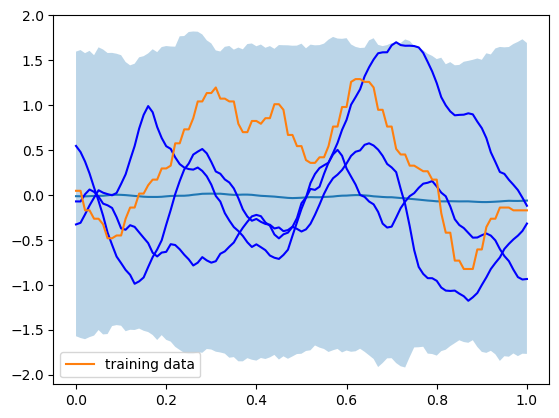

In [ ]:
plt.plot(time, y[:, :, 0].mean(1))
plt.fill_between(time, y[:, :, 0].quantile(0.05, 1), y[:, :, 0].quantile(0.95, 1), alpha=0.3)
plt.plot(time, y[:, [0, 1, 2], 0], color='blue')
plt.plot(time, s[:101, 0], label="training data")
plt.legend()

# Training

For training we use data that is not from the repeating signals (which is gonna be validation data).

In [69]:
def partition(x1, x2, length, overlap=0):
    """
    Splits the interval [x1, x2] into subintervals of length `length` with configurable overlap between the intervals.

    Returns `floor((x2 - x1 - overlap) / (length - overlap))` intervals
    """
    if x1 >= x2:
        raise ValueError("x1 must be less than x2.")
    if length <= 0:
        raise ValueError("length must be a positive number.")
    if overlap < 0 or overlap >= length:
        raise ValueError("overlap must be in range [0, length).")
    
    step = length - overlap
    num_intervals = int((x2 - x1 - overlap) // step)
    
    start_points = np.arange(num_intervals) * step + x1
    end_points = start_points + length
    
    intervals = np.column_stack((start_points, end_points))
    
    return intervals


We choose training intervals of length 4 seconds

In [70]:
INTERVAL_LENGTH = 4 / SECONDS_PER_UNIT
INTERVAL_OVERLAP = INTERVAL_LENGTH // 2

In [71]:
def get_training_intervals(interval_length, overlap=0):
    # initial partition
    yield partition(100 / SECONDS_PER_UNIT, data['rep_begin_time'][0], interval_length, overlap)

    for x1, x2 in zip(data['rep_end_time'][:-1], data['rep_begin_time'][1:]):
        yield partition(x1, x2, interval_length, overlap)

    # final partition
    yield partition(data['rep_end_time'][-1], 8000 / SECONDS_PER_UNIT, interval_length, overlap)

In [126]:
neurons = data['PickedCells'][:1]
neurons

array([4], dtype=uint8)

In [127]:
training_intervals = np.concatenate([x for x in get_training_intervals(INTERVAL_LENGTH, INTERVAL_OVERLAP)])
validation_intervals = np.column_stack((data['rep_begin_time'], data['rep_end_time']))
train_dataset = NeuronDataSet('../data/barmovie0113extended.data', neurons, training_intervals)
validation_dataset = NeuronDataSet('../data/barmovie0113extended.data', neurons, validation_intervals)
torch.stack([t[2] for t in train_dataset]).shape

torch.Size([1704, 400, 1])

In [128]:
def train_model(dataset_path, neurons=[0], name="model"):
    data = scipy.io.loadmat(dataset_path, squeeze_me=True)
    training_intervals = np.concatenate([x for x in get_training_intervals(INTERVAL_LENGTH, INTERVAL_OVERLAP)])
    validation_intervals = np.column_stack((data['rep_begin_time'], data['rep_end_time']))
    train_dataset = NeuronDataSet(dataset_path, neurons, training_intervals)
    validation_dataset = NeuronDataSet(dataset_path, neurons, validation_intervals)

    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True, 
        collate_fn=collate_time_series, 
        num_workers=10
    )
    val_loader = DataLoader(
        validation_dataset,
        batch_size=len(validation_dataset),
        collate_fn=collate_time_series,
    )
    spike_model = SpikeModel(
        len(neurons), 40, 4, model_type="CNN", kernel_size=20
    )
    lr_monitor = LearningRateMonitor(logging_interval="step")

    logger = CSVLogger(save_dir="training_logs", name=name, version="")

    trainer = L.Trainer(
        max_epochs=10, callbacks=[lr_monitor], log_every_n_steps=10, logger=logger
    )
    trainer.fit(
        model=spike_model, train_dataloaders=train_loader, val_dataloaders=val_loader
    )

    return spike_model

In [129]:
spike_model = train_model('../data/barmovie0113extended.data', neurons) 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | net     | ConditionalSpikeCNN | 98.1 K | train
1 | loss_fn | PoissonNLLLoss      | 0      | train
--------------------------------------------------------
98.1 K    Trainable params
0         Non-trainable params
98.1 K    Total params
0.392     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 54/54 [00:08<00:00,  6.40it/s, train_loss=0.0416, val_loss=0.0509, corr=0.757]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:08<00:00,  6.39it/s, train_loss=0.0416, val_loss=0.0509, corr=0.757]


## Training graphs

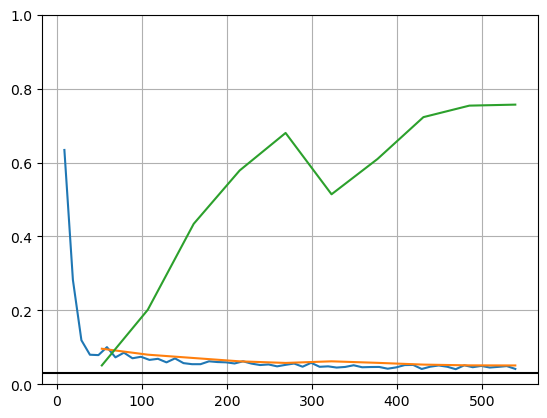

In [130]:
import polars as pl

df = pl.read_csv("training_logs/model/metrics.csv")

lr_data = df.filter(pl.col('lr-Adam').is_not_null())
train_data = df.filter(pl.col('train_loss').is_not_null())
val_data = df.filter(pl.col('val_loss').is_not_null())

plt.axhline(y=0.0314, color='black')
plt.plot(train_data['step'], train_data['train_loss'])
plt.plot(val_data['step'], val_data['val_loss'])
plt.plot(val_data['step'], val_data['corr'])

# plt.yscale('log')
plt.ylim(0, 1)
plt.grid()

In [ ]:
# from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor

# train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, collate_fn=collate_time_series)
# val_loader = DataLoader(validation_dataset, batch_size=len(validation_dataset), collate_fn=collate_time_series)

# spike_model = SpikeModel(len(neurons), 32, 2, model_type='CNN', kernel_size=20)
# # spike_model = SpikeModel(len(neurons), 64, 2, model_type='RNN')

# checkpoint_callback = ModelCheckpoint(
#     dirpath="checkpoints/",    # Directory to save checkpoints
#     filename="{epoch:02d}",  # File name format
#     save_top_k=-1,  # Save all checkpoints
#     every_n_epochs=5,  # Save every N epochs
# )

# lr_monitor = LearningRateMonitor(logging_interval='step')

# # trainer = L.Trainer(max_epochs=150, callbacks=[checkpoint_callback])
# trainer = L.Trainer(max_epochs=50, callbacks=[lr_monitor], log_every_n_steps=1)
# trainer.fit(model=spike_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Validation

In [ ]:
spike_model = SpikeModel.load_from_checkpoint("training_logs/model/checkpoints/epoch=9-step=540.ckpt")
assert isinstance(spike_model.net, ConditionalSpikeCNN)

In [131]:
spike_model.eval()
t_val, s_val, x_val = collate_time_series([v for v in validation_dataset])
model_output = spike_model.net.sample(s_val)

Text(0.5, 0, 'neuron')

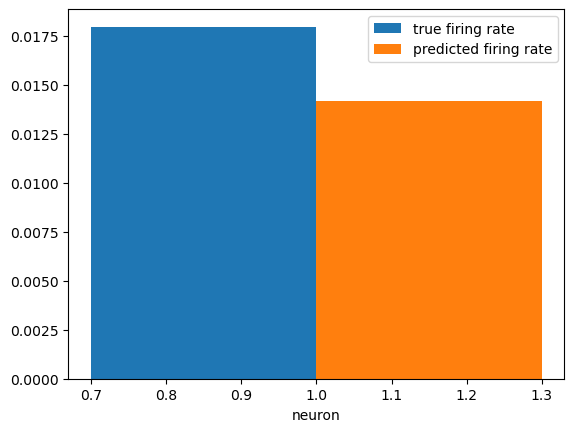

In [132]:
mean_model_rates = model_output.mean((0, 1))
mean_rates = x_val.mean((0, 1), dtype=torch.float32)
plt.bar(np.arange(len(mean_rates)) + 0.85, mean_rates, width=0.3, label="true firing rate")
plt.bar(np.arange(len(mean_rates)) + 1.15, mean_model_rates, width=0.3, label="predicted firing rate")
plt.legend()
plt.xlabel("neuron")

In [133]:
def plot_network_performance(model, out_path=None):
    fig, axs = plt.subplots(1 + model.net.n_neurons, constrained_layout=True)

    axs[0].plot(t_val[:, 0], s_val[:, 0])
    axs[0].set_title("Validation")
    axs[0].set_yticklabels([])

    for i in range(model.net.n_neurons):
        ax = axs[i+1]
        ax.set_ylabel(f'$n_{{{i+1}}}$')
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_ylim(-0.2, 0.2)
        ax.plot(t_val[:, 0], model_output[:, :, i].mean(1), linewidth=1)
        ax.plot(t_val[:, 0], -x_val[:, :, i].mean(1, dtype=torch.float32), linewidth=1)

    if out_path is not None:
        fig.savefig(out_path)
    return fig

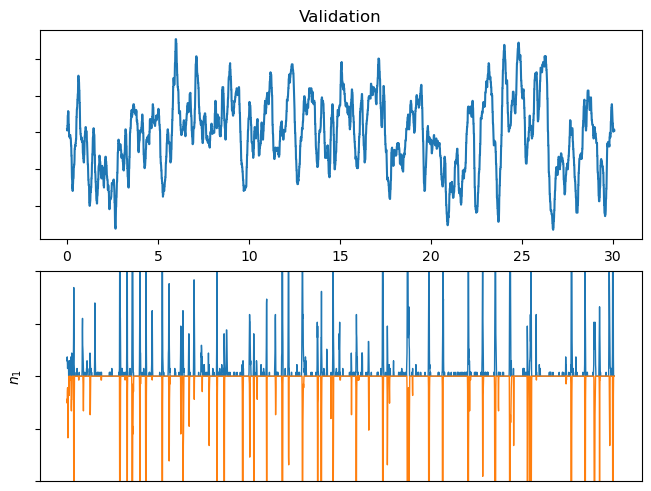

In [134]:
plot_network_performance(spike_model, "../reports/figures/neuron_validation.png");

Plot the Pearson Correlation Coefficients between predicted firing rates at each timestep and measured firing rates

(0.0, 1.0)

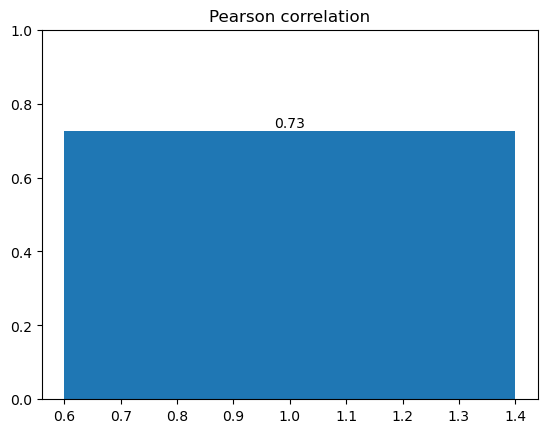

In [135]:
from scipy.stats import pearsonr

def plot_correlation(model, validation_dataset):
    _, _, x_val = collate_time_series([v for v in validation_dataset])
    actual_rate = x_val.mean(1, dtype=torch.float32)
    predicted_rate = model_output.mean(1)
    corr = pearsonr(predicted_rate, actual_rate, axis=0).statistic # pyright: ignore[reportAttributeAccessIssue]
    _, ax = plt.subplots()
    rects = ax.bar(np.arange(len(neurons)) + 1, corr)
    ax.bar_label(rects, fmt = '{:.2f}')

plot_correlation(spike_model, validation_dataset)
plt.title("Pearson correlation")
plt.ylim(0,1)

/data/clusterusers/reinhardt/miniforge3/envs/pyenv/lib/python3.12/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


Text(0.5, 1.0, 'R2 score')

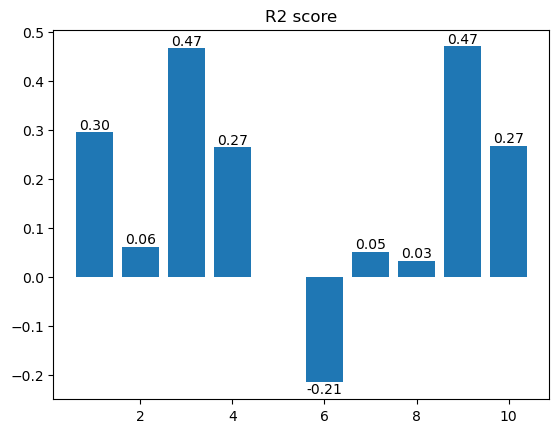

In [729]:
from scipy.stats import pearsonr

def plot_r2(model, validation_dataset):
    t_val, s_val, x_val = collate_time_series([v for v in validation_dataset])
    actual_rate = x_val.mean(1, dtype=torch.float32)
    predicted_rate = model_output.mean(1)
    r2 = 1 - torch.sum((predicted_rate - actual_rate)**2, 0) / torch.sum((actual_rate - actual_rate.mean(0))**2, 0)
    f, ax = plt.subplots()
    rects = ax.bar(np.arange(len(neurons)) + 1, r2)
    ax.bar_label(rects, fmt = '{:.2f}')

plot_r2(spike_model, validation_dataset)
plt.title("R2 score")


# PWS Estimate

In [45]:
t_val, s_val, x_val = collate_time_series([v for v in validation_dataset])
x_val.shape

torch.Size([3008, 136, 10])

In [46]:
def log_probability(model, s, x, cache = None):
    model.eval()
    log_intensity, cache = model(s, x, cache)
    return -F.poisson_nll_loss(log_intensity, x, log_input=True, full=True, reduction='none').sum(-1), cache

In [47]:
BLOCK_SIZE = 5

In [ ]:
stoch_osc = StochasticHarmonicOscillator()
y0 = torch.randn(500, 2) * STATIONARY_SIGMA
y = torchsde.sdeint(stoch_osc, y0, t_val[:42 * BLOCK_SIZE,0], dt=1/200)
assert isinstance(y, torch.Tensor)
s_test = y[:, :, 0]
s_test.shape

torch.Size([210, 500])

In [49]:
x_test = spike_model.net.sample(s_test)
x_test.shape # seq_len, batch_size, n_neurons

torch.Size([210, 500, 10])

## SMC impl

In [50]:
def resample(arr, indices, batch_indices):
    # resampling with index tricks
    extra_dims = arr.ndim - 2
    ii = indices[(Ellipsis,) + (None,)*extra_dims].expand(-1, -1, *arr.shape[2:])
    arr[batch_indices] = torch.gather(arr[batch_indices], dim=1, index=ii)

In [ ]:
class ParticleFilter(nn.Module):
    """
    A bootstrap particle filter.
    """
    def __init__(self, model: nn.Module, x: torch.Tensor, n_particles: int = 128, resample_criterion = None):
        super().__init__()
        seq_len, batch_size, _ = x.shape
        self.batch_size = batch_size
        self.model = model
        self.sho = StochasticHarmonicOscillator()
        self.n = 0 # discrete time
        self.y0 = torch.randn(batch_size, n_particles, 2) * STATIONARY_SIGMA
        self.x = x
        self.n_particles = n_particles
        self.log_marginals = []
        self.cache = None
        self.weights = torch.zeros(batch_size, n_particles)
        self.resample_criterion = n_particles / 2 if resample_criterion is None else resample_criterion
        self.resamples = []

    @torch.no_grad()
    def forward(self, n_end):
        """
        The main particle filter routine.
        
        Advance the particles to `n_end`. This propagates all particles forward in time
        to `n_end * delta_t` where delta_t is the discretization. Computes the
        likelihood-increment for all particles. 

        Then whenever the effective sample size (ESS) drops below half the particle
        count, we resample.
        """
        NM = self.batch_size * self.n_particles
        n = self.n
        self.n = n_end
        
        # STEP 1: Propagate input
        n_range = torch.arange(n, n_end + 1)
        t_grid = n_range * BIN_WIDTH * SECONDS_PER_UNIT
        y = torchsde.sdeint(self.sho, self.y0.view(NM, 2), t_grid, dt=1/100)
        assert isinstance(y, torch.Tensor)
        
        y = y.view((-1, self.batch_size, self.n_particles, 2))
        self.y0 = y[-1, ...]
        s = y[1:, ..., 0]
        
        # STEP 2: Compute likelihood
        s = s.view(n_end - n, NM)
        x = self.x[n:n_end].repeat_interleave(self.n_particles, 1)
        
        logp_increment, self.cache = log_probability(
            self.model, 
            s.view(-1, NM), 
            x,
            self.cache
        )
        logp_increment = logp_increment.reshape((-1, self.batch_size, self.n_particles)).cumsum(0)
        self.log_marginals.append(torch.logsumexp(self.weights + logp_increment, dim=-1) - np.log(self.n_particles))

        self.weights += logp_increment[-1]
        
        ess = 1 / torch.sum(F.softmax(self.weights, dim=1)**2, dim=1)

        # STEP 3: Resample particle state (cache and y0)
        batch_indices = torch.where(ess < self.resample_criterion)[0]
        if len(batch_indices) == 0:
            self.resamples.append((n_end, 0))
            return
            
        dist = torch.distributions.categorical.Categorical(logits=self.weights[batch_indices])
        indices = dist.sample((self.n_particles,)).T

        # resampling
        cache_view = self.cache.view((self.batch_size, self.n_particles) + self.cache.shape[-2:])[:, :, 0]
        resample(cache_view, indices, batch_indices)
        resample(self.y0, indices, batch_indices)
        # reset the weights of all resampled particles to the current log_marginal estimate
        self.weights[batch_indices] = self.log_marginals[-1][-1, batch_indices, None]
        self.resamples.append((n_end, len(batch_indices)))
                

In [54]:
def smc_estimate():
    n_max, batch_size, n_neurons = x_test.shape # max sequence length
    M = 256
    pf = ParticleFilter(spike_model.net, x_test, M)

    for n_end in range(BLOCK_SIZE, n_max+1, BLOCK_SIZE):
        pf(n_end)
    return pf
pf = smc_estimate()
log_marginal = torch.cat(pf.log_marginals) 

In [56]:
with torch.no_grad():
    log_conditional, _ = log_probability(spike_model.net, s_test, x_test)
    log_conditional = log_conditional.cumsum(0)
log_conditional.shape

torch.Size([210, 500])

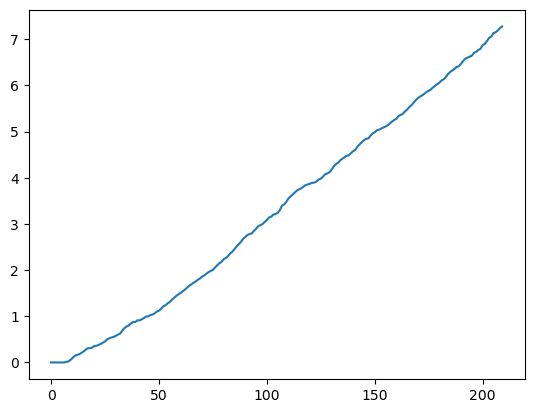

In [57]:
plt.plot((log_conditional - log_marginal).mean(1))

## Direct PWS

In [659]:

def _pws_samples(s_samples, x_samples, M = 1024):
    seq_len, batch_size = s_samples.shape
    log_conditional = log_probability(spike_model.net, s_samples, x_samples).cumsum(0)
    for i in range(batch_size):
        y0 = torch.zeros(M, 2)
        t = t_val[:seq_len, 0]
        y = torchsde.sdeint(stoch_osc, y0, t, dt=1/60)
        s = y[:, :, 0]
        logp = log_probability(spike_model.net, s, x_samples[:, [i], :].repeat(1, M, 1)).cumsum(0)
        log_marginal = logp.logsumexp(1) - np.log(M)
        yield torch.stack((log_conditional[:, i], log_marginal))

def pws_sample(s_samples, x_samples, M = 1024):
    return torch.stack(list(_pws_samples(s_samples, x_samples, M)))

with torch.no_grad():
    samples = pws_sample(s_test, x_test, 512)
samples

tensor([[[-4.5901e-02, -9.1662e-02, -1.3786e-01,  ..., -8.3101e+01,
          -8.3168e+01, -8.3224e+01],
         [-4.5923e-02, -9.1846e-02, -1.3777e-01,  ..., -9.2677e+01,
          -9.2722e+01, -9.2763e+01]],

        [[-4.5226e+00, -4.5684e+00, -4.6141e+00,  ..., -5.9592e+01,
          -5.9623e+01, -5.9646e+01],
         [-4.5232e+00, -4.5692e+00, -4.6151e+00,  ..., -7.1387e+01,
          -7.1474e+01, -7.1549e+01]],

        [[-4.5948e-02, -9.2062e-02, -1.3807e-01,  ..., -7.0538e+01,
          -7.0576e+01, -7.0617e+01],
         [-4.5923e-02, -9.1846e-02, -1.3777e-01,  ..., -7.7572e+01,
          -7.7637e+01, -7.7707e+01]],

        ...,

        [[-4.5930e-02, -9.1908e-02, -1.3806e-01,  ..., -6.3486e+01,
          -6.3537e+01, -6.3587e+01],
         [-4.5923e-02, -9.1846e-02, -1.3777e-01,  ..., -6.9643e+01,
          -6.9689e+01, -6.9731e+01]],

        [[-4.5886e-02, -9.1678e-02, -1.3773e-01,  ..., -5.0208e+01,
          -5.0241e+01, -5.0274e+01],
         [-4.5923e-02, -9.1846e-0

Text(0, 0.5, 'MI [nats]')

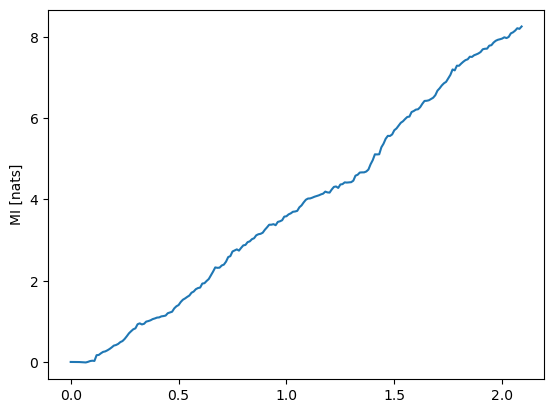

In [668]:
mi = samples[:,0] - samples[:,1]
plt.plot(t_val[:mi.shape[1], 0], mi[:, :].mean(0))
plt.ylabel('MI [nats]')

# Variational PWS

### Encoder

Now create a variational SDE model

In [69]:
class SimpleEncoder(nn.Module):
    def __init__(self, hidden_dim: int = 64, bins=torch.linspace(0.0, 10.0, 126)):
        super().__init__()
        input_dim = bins.size(0) + 2
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )
        self.output_layer = nn.Linear(input_dim, 1)
        self.bins = bins

    def forward(self, t, y, _context):
        dt = self.bins - t
        t_emb = torch.exp(-0.5 * dt**2 / 0.1**2).expand(y.size(0), -1) # (N, d_emb)
        x = torch.cat([y, t_emb], dim=-1) # (N, d)

        x = self.net(x) + x
        return self.output_layer(x).squeeze(-1)

In [70]:
class VariationalEncoder(nn.Module):
    def __init__(self, query_dim: int, feature_dim: int, hidden_dim: int = 512, n_heads=8):
        super().__init__()

        self.nheads = n_heads
        self.E_head = hidden_dim // n_heads

        self.q_proj = nn.Linear(query_dim, hidden_dim)
        self.k_proj = nn.Linear(feature_dim, hidden_dim)
        self.v_proj = nn.Linear(feature_dim, hidden_dim)

        self.feedforward = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, t, y, context):
        t_emb = positional_embedding(t).expand(y.size(0), -1)
        query = torch.cat([y, t_emb], dim=-1).unsqueeze(1) # (N, L=1, signal_dim)
        context = context.unsqueeze(0) # (N, num_spikes, feature_dim)
        
        # (N, L_t, hidden_dim) -> (N, L_t, nheads, E_head) -> (N, nheads, L_t, E_head)
        query = self.q_proj(query).unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)
        key = self.k_proj(context).unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)
        value = self.v_proj(context).unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)

        # (N, nheads, L=1, E_head)
        x = nn.functional.scaled_dot_product_attention(query, key, value)
        x = x + query # residual connection

        # (N, L=1, hidden_dim)
        x = x.transpose(1, 2).flatten(-2)

        return self.feedforward(x).squeeze((-2, -1))

In [71]:
batch_size = 25
num_spikes = 7
feature_dim = 13
# var_enc = VariationalEncoder(8 + 2, feature_dim)
var_enc = SimpleEncoder()
var_enc(torch.tensor(0.5), torch.rand(batch_size, 2), torch.rand(7, feature_dim))

tensor([-0.1777, -0.1757, -0.1525, -0.1596, -0.1529, -0.1542, -0.1617, -0.1737,
        -0.1559, -0.1760, -0.1628, -0.1695, -0.1776, -0.1724, -0.1790, -0.1563,
        -0.1643, -0.1662, -0.1493, -0.1660, -0.1496, -0.1532, -0.1616, -0.1561,
        -0.1745], grad_fn=<SqueezeBackward1>)

In [72]:
class VariationalSDE(nn.Module):
    def __init__(self, base_model: nn.Module, encoder: nn.Module, context: torch.tensor):
        super().__init__()
        self.context = context
        self.base_model = base_model

        self.noise_type = base_model.noise_type
        self.sde_type = base_model.sde_type

        self.encoder = encoder

    # Drift
    def f(self, t, y):
        drift = self.base_model.f(t, y)
        drift[:, 1] += self.encoder(t, y, self.context)
        return drift

    # Diffusion
    def g(self, t, y):
        return self.base_model.g(t, y)

    # Base measure
    def h(self, t, y):
        return self.base_model.f(t, y)

In [73]:
class VariationalConditionalSDE(nn.Module):
    def __init__(self, n_neurons, sde_dt = 1/60):
        super().__init__()

        self.prior_sde = StochasticHarmonicOscillator()
        # self.encoder = VariationalEncoder(2 + 8, n_neurons + 8, n_neurons * 8)
        self.encoder = SimpleEncoder(128)

        self.sde_dt = sde_dt

    def forward(self, t: torch.tensor, x_emb: torch.tensor, batch_size: int = 1):
        sde = VariationalSDE(self.prior_sde, self.encoder, x_emb)
        y0 = torch.zeros((batch_size, 2))
        y, logqp = torchsde.sdeint(sde, y0, t, method='euler', dt=self.sde_dt, logqp=True)
        return y[...,0], logqp.sum(0).mean()
        

### Lightning Module

In [ ]:
class VariationalModel(L.LightningModule):
    def __init__(self, forward_model, backward_model, variational_samples=128):
        super().__init__()
        self.forward_model = forward_model
        self.backward_model = backward_model

        self.forward_model.eval()
        self.forward_model.requires_grad_(False)

        self.variational_samples = variational_samples
        
    def training_step(self, batch, batch_idx):
        t, s, x, x_emb = batch

        assert len(x_emb) == 1

        t = t[:, 0].contiguous()
        x_emb = x_emb[0]
        
        s, kl_div = self.backward_model(t, x_emb, self.variational_samples)

        x_expanded = x.expand(-1, self.variational_samples, -1)
        logp_forward = log_probability(self.forward_model, s, x_expanded).sum((0,-1)).mean()

        self.log("kl_div", kl_div)
        self.log("logp", logp_forward)

        # ELBO
        train_loss = -(logp_forward - kl_div)

        self.log("train_loss", train_loss)
        return train_loss

    def configure_optimizers(self): # type: ignore
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=1e-1)
        total_steps = self.trainer.estimated_stepping_batches
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-1, total_steps=total_steps)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            }
        }

In [75]:
test_t, test_s, test_x, test_x_emb = validation_dataset[0]

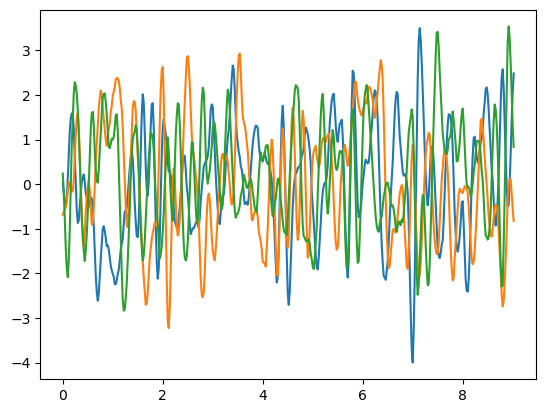

In [76]:
# stoch_osc = StochasticHarmonicOscillator(50e-3, 1e3, 9.42)
# backward_model = VariationalConditionalSDE(len(neurons))

backward_model = VariationalGP(torch.arange(test_t.min(), test_t.max(), 0.1))

s, logqs = backward_model(test_t, test_x_emb, 3)
plt.plot(test_t, s.detach())

In [77]:
forward_model = spike_model.net
variational_model = VariationalModel(forward_model, backward_model)
variational_model

VariationalModel(
  (forward_model): ConditionalSpikeCNN(
    (conv_net): Sequential(
      (0): ZeroPad1d((18, 0))
      (1): Conv1d(1, 16, kernel_size=(10,), stride=(1,))
      (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Conv1d(16, 16, kernel_size=(10,), stride=(1,))
      (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Conv1d(16, 10, kernel_size=(1,), stride=(1,))
    )
  )
  (backward_model): VariationalGP(
    (kernel): StochasticHarmonicOscillatorKernel()
  )
)

In [78]:
trainer = L.Trainer(max_epochs=15, log_every_n_steps=1)
trainer.fit(model=variational_model, train_dataloaders=DataLoader(validation_dataset, shuffle=True, collate_fn=collate_time_series))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.
/data/clusterusers/reinhardt/miniconda3/envs/ml-pws/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | forward_model  | ConditionalSpikeCNN | 3.0 K  | eval 
1 | backward_model | VariationalGP       | 8.4 K  | train
---------------------------------------------------------------
8.4 K     Trainable params
3.0 K     Non-trainable params
11.4 K    Total params
0.045     Total estimated model params size (MB)
2         Modules in train mode
10        Modu

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


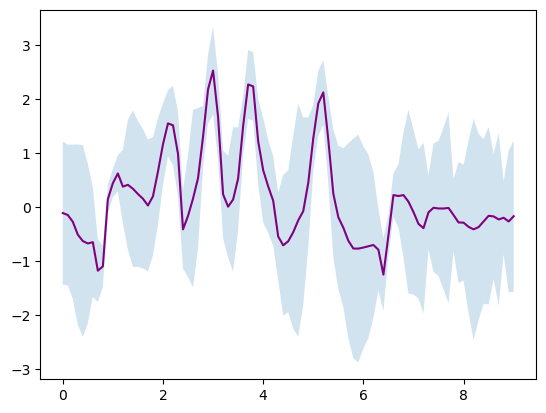

In [79]:
gp_var = variational_model.backward_model
S_L = gp_var.get_sl().detach()
mu = gp_var.m[:, 0].detach()
sigma = torch.diag(S_L @ S_L.T).sqrt()
plt.fill_between(gp_var.t_obs, mu - 2*sigma, mu + 2*sigma, alpha=0.2)
plt.plot(gp_var.t_obs, mu, color='purple')

In [80]:
test_t, test_s, test_x, test_x_emb = validation_dataset[0]

In [81]:
with torch.no_grad():
    posterior_samples, kl_div = variational_model.backward_model(test_t, test_x_emb, 4096)

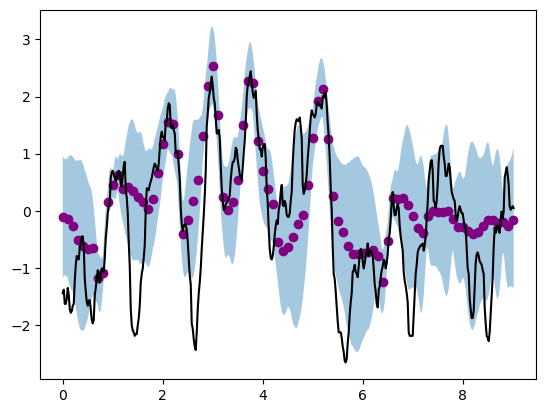

In [87]:
plt.fill_between(test_t, *posterior_samples.quantile(torch.tensor([0.05, 0.95]), dim=1), alpha=0.4)
plt.plot(test_t, test_s, color='black')
gp_var = variational_model.backward_model
plt.scatter(gp_var.t_obs, gp_var.m[:, 0].detach(), color='purple')

In [110]:
durations = np.arange(1, 100, 15)
test_t[durations]

tensor([0.0200, 0.3200, 0.6200, 0.9200, 1.2200, 1.5200, 1.8200])

Compute the marginal probability for duration $\tau$.

$$
\mathrm{P}(x_{t:t+\tau}|x_{<t}, s_{<t}) = \left\langle \mathrm{P}(x_{t:t+\tau}|s_{t:t+\tau},x_{<t},s_{<t}) \frac{\mathrm{P}(s_{t:t+\tau}|s_{<t})}{q(s_{t:t+\tau}|s_{<t})} \right\rangle_{q(s_{t:t+\tau}|s_{<t})}
$$

In [ ]:
mi_estimates = torch.zeros(len(durations))
with torch.no_grad():
    log_conditional = log_probability(spike_model.net, test_s.unsqueeze(1), test_x.unsqueeze(1)).sum(-1).squeeze(1)
    logp_forward = log_probability(spike_model.net, posterior_samples, test_x.unsqueeze(1)).sum(-1)
    for k, duration in enumerate(durations):
        # sum pooling
        w = F.lp_pool1d(logp_forward.T, 1, duration, 1)

        # calculate importance weights log(q/p) and subtract them from the pooled logp
        for i in range(w.size(1)):
            importance_weights = gp_var.importance_weights(test_t[i:i+duration], posterior_samples[i:i+duration])
            w[:, i] -= importance_weights

        # average in log space
        logN = np.log(w.size(0))
        w = w.logsumexp(0) - logN
        mi_estimates[k] = log_conditional.mean() * duration - w.mean()

Text(0.5, 0, 'duration (s)')

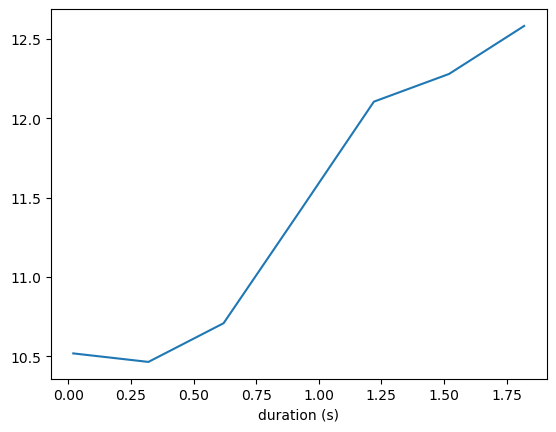

In [134]:
plt.plot(test_t[durations], mi_estimates * np.log(2))
plt.xlabel('duration (s)')

In [84]:
with torch.no_grad():
    logp_forward = log_probability(spike_model.net, posterior_samples, test_x.unsqueeze(1)).sum(-1)
    kl_div = variational_model.backward_model.kl_div(test_t)
logp_forward.shape, kl_div.shape # (length)

(torch.Size([452, 4096]), torch.Size([451]))

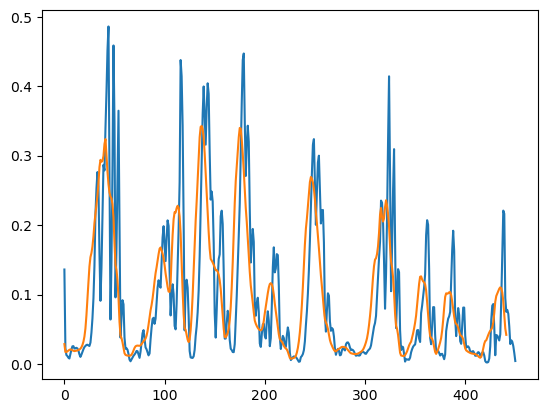

In [ ]:

plt.plot(kl_div)
plt.plot(F.lp_pool1d(kl_div.unsqueeze(0), 1.0, 10, 1).T / 10)

In [ ]:
def 

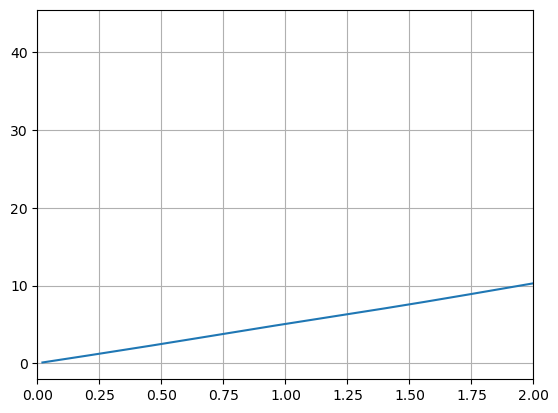

In [130]:
N = kl_div.size(0)
filters = torch.ones((N, N)).tril().unsqueeze(1)
mi = nn.functional.conv1d(kl_div.reshape((1, -1)), filters, padding=filters.size(0))
mask = torch.cat([torch.zeros((N, N)), torch.ones((N, 1)), 1 - filters.squeeze(1).flip(1)], dim=1)
plt.plot(test_t[1:], (mi * mask).sum(1) / mask.sum(1))
plt.xlim(0,2)
plt.grid()

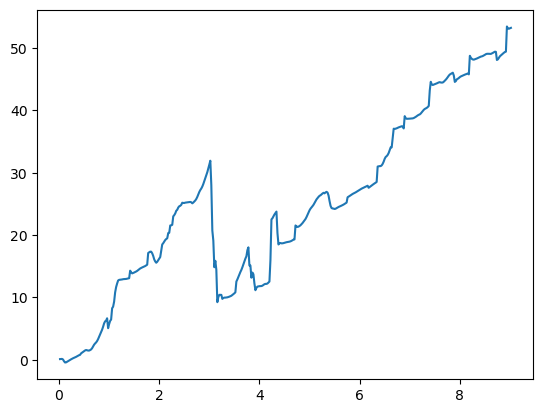

In [159]:
# ELBO
log_marginal_lb = logp_forward[1:].mean(1) - kl_div
log_conditional = log_probability(spike_model.net, test_s.unsqueeze(1), test_x.unsqueeze(1)).sum((-2, -1))
dkl = log_conditional[1:] - log_marginal_lb
plt.plot(test_t[1:], dkl.cumsum(0))

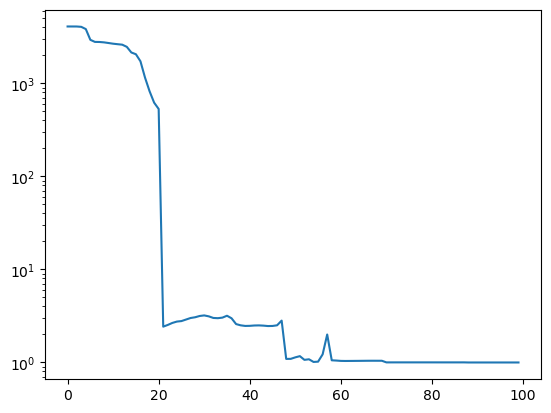

In [132]:
ess = (1 / (nn.functional.softmax(dkl.cumsum(0)[:100], 1) ** 2).sum(1))
plt.plot(ess)
plt.yscale('log')

(0.0, 2.0)

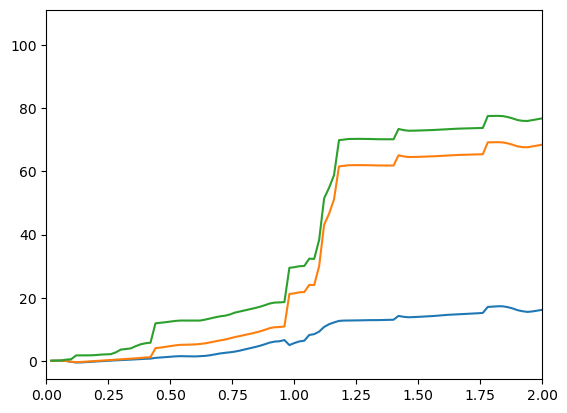

In [133]:
plt.plot(test_t[1:], dkl.cumsum(0).mean(1))
plt.plot(test_t[1:], dkl.cumsum(0).logsumexp(1) - np.log(dkl.size(1)))
plt.plot(test_t[1:], dkl.cumsum(0).max(1)[0])
plt.xlim(0, 2)

In [134]:
length = range(1, 100, 10)
mi, ess = bootstrap_mi_estimate(dkl, length, n_bootstrap=512)

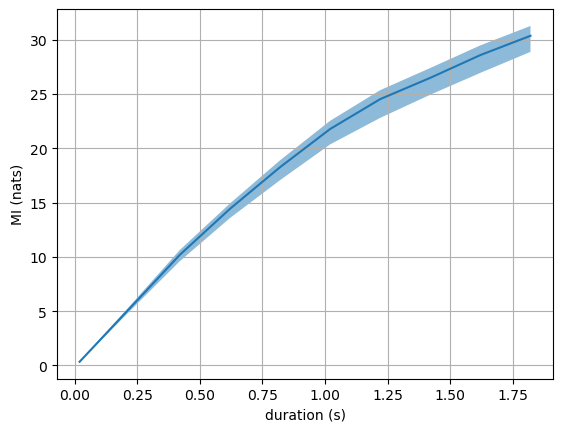

In [135]:
upper = torch.quantile(mi, 0.95, dim=1)
lower = torch.quantile(mi, 0.05, dim=1)
plt.fill_between(t_val[length, 0], lower, upper, alpha=0.5)
plt.plot(t_val[length, 0], torch.mean(mi, dim=1))
plt.xlabel('duration (s)')
plt.ylabel('MI (nats)')
plt.grid()

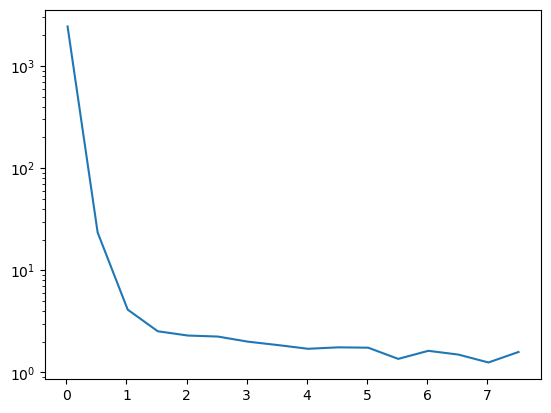

In [354]:
plt.plot(t_val[length, 0], ess)
plt.yscale('log')

# Data Analysis

In [2]:
from pathlib import Path
import json
import numpy as np
from matplotlib import pyplot as plt

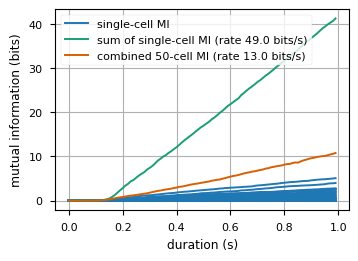

In [3]:
def plot_results(json_folder: Path, pattern: str = "out_*.json"):
    """
    Read JSON files from the specified folder, process them, and plot a line per neuron.

    Args:
        json_folder (Path): Path to the folder containing JSON output files.
        pattern (str): Glob pattern to match result files. Default is "out_*.json".
    """
    json_files = sorted(json_folder.glob(pattern))
    
    if not json_files:
        print("No JSON files found.")
        return

    fig, ax = plt.subplots(figsize=(250 / 72, 180 / 72), constrained_layout=True)
    ax.set_prop_cycle(plt.cycler(color=plt.get_cmap('Dark2').colors))

    mi_total = []

    for file in json_files:
        with open(file, "r") as f:
            data = json.load(f)
            result = data['pws_result']
            t = np.array(result['t'])
            mi = np.array(result['mutual_information']) / np.log(2)
            
            if len(mi_total) == 0:
                ax.plot(t, np.mean(mi, axis=0), color='C0', label='single-cell MI')
            else:
                ax.plot(t, np.mean(mi, axis=0), color='C0')

            mi_total.append(np.mean(mi, axis=0))

    sum_mi = np.sum(np.stack(mi_total), axis=0)
    rate = (sum_mi[-1] - sum_mi[30]) / (t[-1] - t[30])
    ax.plot(t, sum_mi, label=f'sum of single-cell MI (rate {np.round(rate, 1)} bits/s)')

    with open(json_folder / 'full_out.json') as f:
        data = json.load(f)
        result = data['pws_result']
        t = np.array(result['t'])
        mi = np.clip(np.array(result['mutual_information']) / np.log(2), 0.0, 40.0)
        mi_mean = np.nanmean(mi, axis=0)
        rate = (mi_mean[-1] - mi_mean[30]) / (t[-1] - t[30])
        ax.plot(t, mi_mean, label=f'combined 50-cell MI (rate {np.round(rate, 1)} bits/s)')

    ax.set_xlabel('duration (s)')
    ax.set_ylabel('mutual information (bits)')

    ax.legend()
    ax.grid()

    # ax.set_xlim(0, 0.5)
    # ax.set_ylim(0, 10)

    return fig

plt.style.use('seaborn-v0_8-paper')
with plt.rc_context({'font.size': 8, 'lines.markersize': 5}):
    fig = plot_results(Path('../experiments/experiment2'));

fig.savefig('../reports/figures/neurons_mi.pdf')